# Analysis of atmospheric temperature data


Atmospheric temperature is a key parameter in atmosphere modelling and weather forecasting. In this workshop we analyze atmospheric temperature data. The data consists of a 30-years time series of atmospheric temperature measurements, with one measurement per day (actually the daily mean temperature) at a location in the Netherlands. 

- The first column is the date, expressed in calendar format (e.g. 20160517 for 17-MAY-2016), and we will use just time expressed in days instead.
- The second column is the atmospheric temperature in degrees (Celsius), though expressed in units of 0.1 degrees (probably in order to avoid decimal numbers in the registration).

We begin by loading the data and plotting it. The data was (and can still be) obtained from the Royal Netherlands Meteorological Institute (KNMI) in De Bilt: (https://daggegevens.knmi.nl/). We consider in this GA the daily mean temperature (TG: etmaalgemiddelde temperatuur (in 0.1 graden Celsius)) for one location, for a duration of 30 years (01-JAN-1991 - 31-DEC-2020). You can retrieve yourself the data for a location of your choice (using the same time-frame), or you can work with one of the five prepared time series (for five locations around the country): De Bilt, Eelde (near Groningen), de Kooy (near Den Helder), Vlissingen and Maastricht. Preparations involved converting the file from .csv into a plain ASCII-file, and removing the leap-days (29-FEB), simply for convenience in this GA, to have exactly 365 days, every year. The resulting time series is regular and has no missing data values.

## Part 0: Load the data and plot it
This week we are using a new library called `statsmodels`. Make sure you use the environment with this library included as done in the PA!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram

To load the data from the prepared time series you can use the code below.

In [2]:
import os
from urllib.request import urlretrieve

def findfile(fname):
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve('https://github.com/TUDelft-MUDE/source-files/raw/main/file/'+fname, fname)

findfile('DeBilttextm0229.txt')


In [3]:
# Uncomment the dataset you wish to work with!
# default space as delimiter
# these data-files have been retrieved from the KNMI-website
# but they have been slightly customized (from csv to plain text, and leap-days have been removed, as to have 365 days in every year)

inputdata = np.loadtxt('DeBilttextm0229.txt')
#inputdata = np.loadtxt('Eeldetextm0229.txt')
#inputdata = np.loadtxt('DeKooytextm0229.txt')
#inputdata = np.loadtxt('Vlissingentextm0229.txt')
#inputdata = np.loadtxt('Maastrichttextm0229.txt')

time = inputdata[:, 0]
data = inputdata[:, 1]
time = np.linspace(1,len(data),len(data))
print(f'number of elements in this time series {len(data)}')
# we will ignore the time in the first column (as given in calendar days, like 19900101), and use instead time running from 1 to N days
# the daily mean temperature is given in [0.1 deg]; we leave it like this

number of elements in this time series 10950


If instead (otherwise just skip the next cell) you want to use data, which you downloaded yourself from KNMI (https://daggegevens.knmi.nl/), don't forget to remove the leap days (29-FEB) and to double-check that there is no empty data included (there can be missing data for some stations, especially in 1991). The programming assignment PA from week 1.4 can help for data cleaning.**You can also use the cell below to help you.**

Now you are ready to set the time step, sampling frequency and to plot the data.

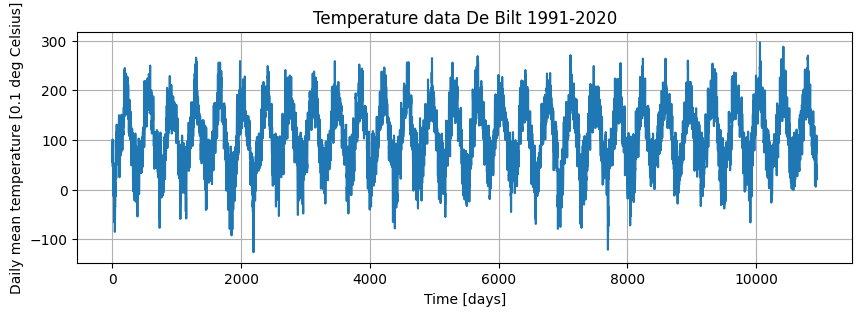

In [4]:
dt = 1  # interval of 1 day
fs = 1 / dt

plt.figure(figsize=(10, 3))
plt.plot(time,data)
plt.xlabel('Time [days]')
plt.ylabel('Daily mean temperature [0.1 deg Celsius]')
plt.title('Temperature data De Bilt 1991-2020')
plt.grid(True)


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 0.1:</b>   

Include the time series plot in your report.

</p>
</div>

## Part 1: Finding frequencies of periodic patterns

We clearly see that the data contains a seasonal pattern. We start by fitting a functional model to the data in order to make the data stationary. To find the frequency of the seasonal pattern we will use the power spectrum of the data (periodogram), see Section 4.3 ['Time Series modelling and estimation'](https://mude.citg.tudelft.nl/book/2025/time_series/modelling.html) of the textbook.

The time series may actually be influenced by **multiple** periodic signals at different frequencies; therefore we apply a method to find the dominant frequency, and then 'remove' the corresponding signal from the data (by accounting for it in the functional model, i.e. the A-matrix), and next try again. In this way, multiple periodic signals are handled one-by-one, in an **iterative procedure**.

Therefore we create a function `find_frequency` that will take the data and a given $\mathrm{A}$-matrix as input, and return the frequency of the most dominant periodic signal. The A-matrix is built step-wise (each time expanded by adding one or more columns) in order to account eventually for all functional components (including the periodic ones) in the data.

Note that we cannot have an empty A-matrix when running the function for the first time. Therefore, later with **Task 1.3**, we define, to start with, an A matrix for a basic linear model that accounts for an intercept and slope, with which `find_frequency` will then de-trend the time series.

The function will look like this:

1. Using the input $\mathrm{A}$-matrix we fit a model to the data using the least squares method. 
2. We calculate the PSD (periodogram) of the residuals of the model.
3. We find the frequency of the most dominant periodic signal in the PSD.
4. Optional: we can plot the power spectrum of the data (periodogram) with the highest peak.



### Create the necessary functions

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 1.1:</b>   

Read the code in the next Python cell and study the contents until you understand what the functions are doing. Then complete the missing parts of the code.

</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Tip:</b>
We will write functions that return multiple parameters, but if we are not interested in defining a particular parameter we can use `_` to ignore it. For example, if we write <code>_, b = function(a)</code>, we only define the second output of the function; the first output is not stored in a variable.</p></div>

In [5]:
def fit_model(data, time, A, plot=False):
    '''
    Function to find the (unweighted) least squares solution of the data,
    needed in the function 'find_frequency' below
    data: input data
    time: time vector
    A: A-matrix of model to fit the data
    plot: boolean to plot the results or not
    '''

    x_hat = np.linalg.solve(A.T @ A, A.T @ data)
    y_hat = A @ x_hat
    e_hat = data - y_hat

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(time, data, label='Observed temp')
        plt.plot(time, y_hat, label='Estimated temp')
        plt.xlabel('Time [days]')
        plt.ylabel('Daily mean temperature [0.1 deg Celsius]')
        plt.title('Observed vs Estimated data')
        plt.grid(True)
        plt.legend()
        plt.subplot(212)
        plt.plot(time, e_hat, label='Residuals')
        plt.xlabel('Time [days]')
        plt.ylabel('Daily mean temperature [0.1 deg Celsius]')
        plt.title('Residuals')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

    return x_hat, y_hat, e_hat

def find_frequency(data, time, A, fs, plot=True):
    '''
    Function to find the dominant frequency of the signal
    data: input data
    time: time vector
    A: A-matrix of model to detrend the data (prior to spectral analysis)
    fs: sampling frequency
    plot: boolean to plot the psd or not
    '''
    # Detrending the data
    _, _, e_hat= fit_model(data, time, A)

    N = len(data)

    # Finding the dominant frequency in e_hat
    freqs, pxx = periodogram(e_hat, fs=fs, window='boxcar',
                             nfft=N, return_onesided=False,
                             scaling='density')

    # finding the dominant frequency and amplitude
    dominant_frequency, amplitude = freqs[np.argmax(pxx)], np.max(pxx)

    # Plotting the PSD
    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(time, e_hat)
        plt.title('Residuals')
        plt.ylabel('Daily mean temperature [0.1 deg Celsius]')
        plt.grid(True)
        plt.subplot(212)
        plt.plot(freqs[freqs>0], pxx[freqs>0], label='PSD of residuals')
        plt.xlabel('Frequency')
        plt.ylabel('PSD')
        plt.title('Power Spectral Density')
        plt.grid(True)
        plt.plot(dominant_frequency, amplitude, 'ro', label='Dominant Frequency')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.tight_layout()

    return dominant_frequency


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 1.2:</b>   

How can we use the <code>find_frequency</code> function to find the frequencies of all periodic pattern in the data? In other words, how can we iteratively detect the frequencies in the data? 'Removing' periodic patterns is done by actually accounting for them in the functional model, through the A-matrix.

Write your answer, detailing the procedure, in a bulleted list that describes the procedure in your report.

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Solution:</b>   

- Step 1: Run the function
- Step 2: Find dominant frequency
- Step 3: Add the column(s) (corresponding to the new parameter(s)) to the A matrix
- Step 4: Repeat (iterate)

</p>
</div>

### Find the first dominant frequency

Now we run `find_frequency` repeatedly to find the 'frequencies' in the data. For the first iteration we use an $\mathrm{A}$-matrix that 'removes' a linear trend (with intercept and slope) from the data. Once we have found a frequency, we also 'remove' the corresponding periodic signal from the data in the next iteration.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 1.3:</b>   

Set up the $\mathrm{A}$-matrix for a linear trend, to 'remove' it from the data, then find the most dominant frequency in the least-squares residuals time series (include the resulting periodogram plot in your report) and print the result.

The default units of frequency may be cumbersome to interpret, so you should convert the result to a more suitable unit.

</p>
</div>

Dominant_Frequency: 0.003 cycle/day
Dominant Frequency: 1.000 cycle/year


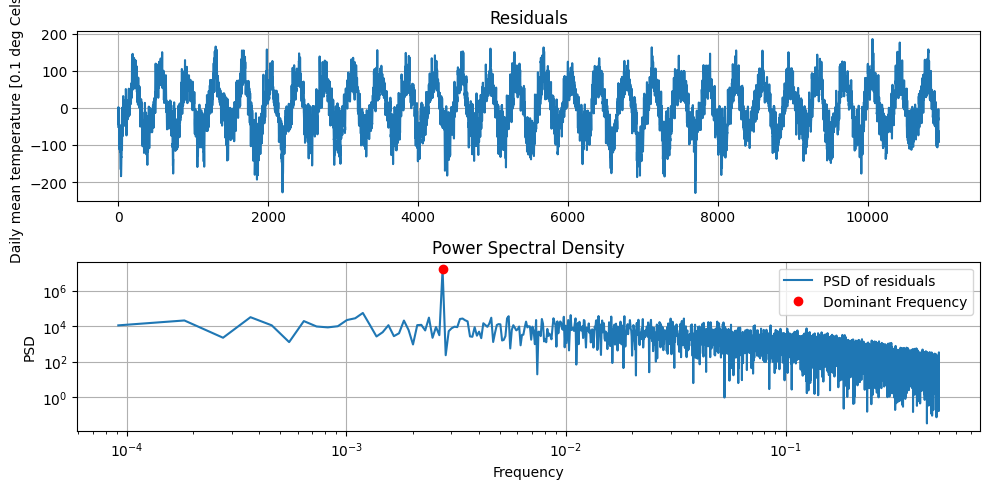

In [6]:
A = np.column_stack((np.ones(len(data)), time))
dom_f = find_frequency(data, time, A, fs)
print(f'Dominant_Frequency: {dom_f:.3f} cycle/day')
print(f'Dominant Frequency: {dom_f*365:.3f} cycle/year')

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 1.4:</b>   

Look back at the plot of the original time series (in Part 0, task 0.1) and confirm whether or not you can see the presence of the periodic signal with the frequency found in the previous task. Write your answer in one sentence in your report.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Solution:</b>   
<p>
Yes there is a clear yearly pattern in the data (as expected). 
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

<b>Task 1.5:</b>

Try to find a second frequency by repeating the process. Before using <code>find_frequency</code> again, the linear trend and now also the first periodic component should be accounted for (through the A-matrix). The periodic component with the first dominant frequency $f_1$ can be incorporated in the model (A-matrix) through:

$$a_1  \cos(2\pi f_1  t) + b_1  \sin(2\pi f_1 t)$$

Repeat this step until you have 'removed' all dominant periodic components of the signal (you will have to determine when to stop).

Print the frequencies of all periodic components found in the data.
</p>
</div>

Dominant Frequency: 0.001 cycle/day


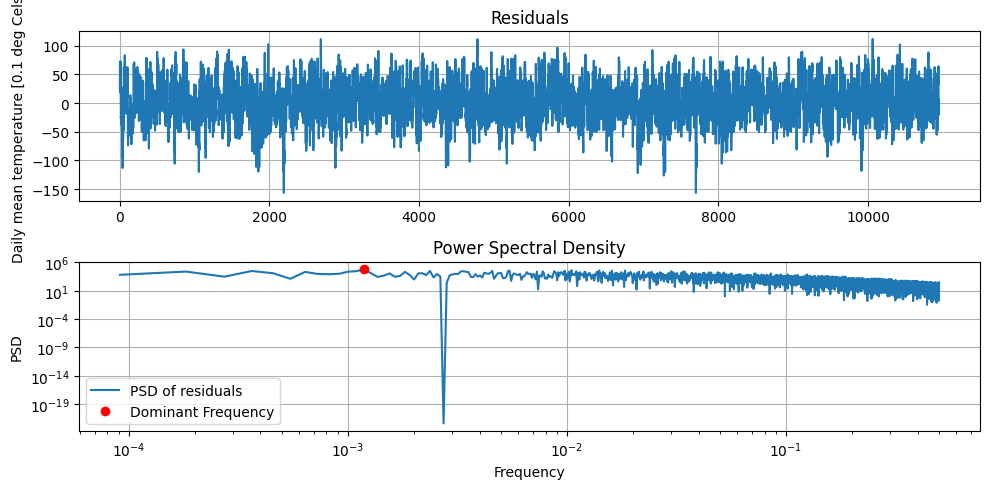

In [7]:
A2 = np.column_stack((A, np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time)))
dom_f2 = find_frequency(data, time, A2, fs)
print(f'Dominant Frequency: {dom_f2:.3f} cycle/day')

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 1.6:</b>   

Describe the steps taken in the previous task and the outcomes, and explain in your own words how the dominant frequencies were determined (list them in your report).

How did you decide when to stop? Which frequencies do you consider to be dominant? Include in your report the periodogram plot resulting from running <code>find_frequency</code> for the second time.

Is the final (detrended) time series (i.e. the final least-squares residuals) stationary? Explain. Include your answers in the report.

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Solution:</b>   
<p>

- First run: we fit a linear model (with intercept and slope) to the data and find the dominant frequency of 1 cycle per year. This one clearly stands out in the PSD (periodogram) of the residuals, hence the present residual time series is not stationary, so we need to do this step again.
- Second run: we fit a model with a linear trend and now also a yearly cycle. There is no (real, significant) dominant frequency left, the spectrum (PSD) is pretty flat.
- The previous point confirms that the detrended series is indeed stationary (there are no significant periodic patterns remaining). The bottom line is that we need the linear trend, and the yearly cycle in the functional model, resulting in a stationary time series for the residuals.

</p>
</div>

## Part 2: Fitting the functional model

In the next cell we will fit the **final functional model**, found in Part 1 (basically we repeat here the usage of `fit_model` in Task 1.5), to generate a **stationary time series of residuals**. For each dominant periodic component with frequency $f_i$, the following model is used:

$$a_i  \cos(2\pi f_i  t) + b_i  \sin(2\pi f_i t) $$

However, to interpret and report a periodic signal we would like to have the amplitude, phase shift and the frequency of a periodic signal, which can be recovered from:

$$A_i  \cos(2\pi f_i  t + \theta_i)$$

where the amplitude $A_i = \sqrt{a_i^2 + b_i^2}$ and phase shift $\theta_i = \arctan(-b_i/a_i)$, see Section 4.1 in the textbook.


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 2.1:</b>   
<p>

Complete the missing parts of the code cell below to create the functional model.

</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>

If you want to compute the $\theta_i$ you can use the <code>np.arctan2</code> function. This function is a version of the arctan function that returns the angle in the correct quadrant $\theta_i \in [-\pi,\pi]$. Using the <code>np.arctan</code> function may not give you the correct angle!</p></div>

In [8]:
def rewrite_seasonal_comp(a_k, b_k):
    '''
    Function to rewrite the seasonal component, given in terms of sin and cos, as a single cosine (with amplitude and phase shift)
    a_k: seasonal component coefficient for cos
    b_k: seasonal component coefficient for sin
    '''
    A_k = np.sqrt(a_k**2 + b_k**2)
    theta_k = np.arctan2(-b_k, a_k)
    
    return A_k, theta_k

# creating the A matrix of the functional model
# in this case there are four unknown parameters in the model (hence A takes four columns)

A = np.column_stack((   np.ones(len(data)), time,
                        np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time) ))

# Finding the (unweighted) least squares solution using the earlier fit_model function

x_hat, y_hat, e_hat = fit_model(data, time, A)

# Extracting the seasonal component coefficients from the estimated parameters

a_i = np.array([x_hat[2]])
b_i = np.array([x_hat[3]])
freqs = np.array([dom_f])

print(f'Estimated Parameters:')
for i in range(len(x_hat)):
    print(f'x{i} = {x_hat[i]:.3f}')

print('\nThe seasonal component is rewritten as:')
i = 0
for a, b, f in zip(a_i, b_i, freqs):
    A_i, theta_i = rewrite_seasonal_comp(a, b)
    i = i + 1
    print(f'A_{i} = {A_i:.3f}, theta_{i} = {theta_i:.3f}, f_{i} = {f:.3f}')

Estimated Parameters:
x0 = 99.820
x1 = 0.001
x2 = -70.817
x3 = -24.768

The seasonal component is rewritten as:
A_1 = 75.024, theta_1 = 2.805, f_1 = 0.003




<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 2.2:</b>   
<p>

- Include the numerical parameter estimates in your report.

- What can you say about the parameters, do the parameter estimates make sense? 

- What time of the year is the temperature highest (on average)?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Solution:</b>   

<p>

Yes, the parameters' estimates make sense. The average temperature (in the Netherlands) is about 10 degrees Celsius (the intercept, given in 0.1 degrees); the slope is close to 0 (0.1 degrees Celsius per 1000 days). Looking at the periodic signal we can see that the yearly parameter for $\theta$ is 2.8, a little less than $\pi$, which would correspond to half a period. Therefore, the cosine shifts to the left (by almost half a wavelength) and the temperature is lowest in winter and highest in summer, which would make sense physically for this location on the Northern hemisphere. Highest daily temperature occurs slightly after July 1st (somewhere mid-July).

</p>
</div>

## Part 3: Analyzing the residuals - developing the stochastic model
Now that we have our (stationary) time series of residuals, we can fit an AutoRegressive (AR) noise model to these residuals. We start by plotting the ACF of the residuals. We then fit an AR model to the residuals and report the parameter(s) of the AR model.

### Plot the ACF of the residuals


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 3.1:</b>   

Use the <code>plot_acf</code> function (from statsmodels) to plot the ACF (normalized autocovariance function) $\hat{\rho}_{\tau}$ of the residuals from the least-squares model fit of Part 2. The Autocovariance function (ACF) is covered in Section 4.5 of the textbook. 

</p>
</div>

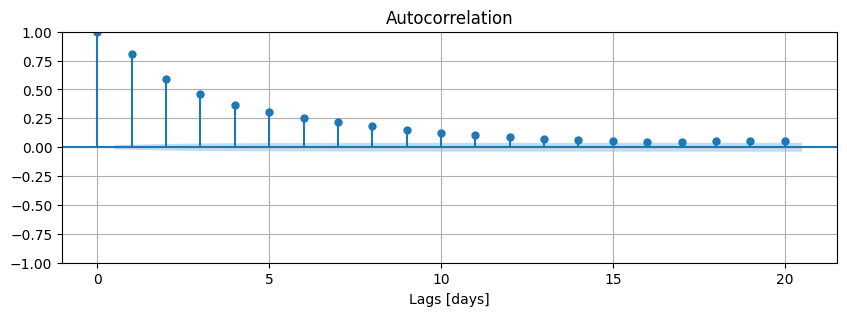

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat, ax=ax, lags=20);
ax.set_xlabel('Lags [days]')
ax.grid()



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Task 3.2:</b>   
<p>
Include the ACF plot in your report. What can you conclude from this ACF? Do the residuals originate from a white noise process?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Solution:</b>   
<p>
The data (time series of residuals) are clearly autocorrelated (colored noise, definitely not white noise); the normalized autocovariance is significantly non-zero, up to about lag 10.

The residuals do not originate from a white noise process; they show some kind of 'memory' (over a duration of about 10 days).
</p>
</div>

### Fit an AR(1) model to the residuals

First we write a function `AR1` that takes the stationary time series of residuals as input and returns the parameters of the AR1 model. Then we fit this model to the residuals and report the parameters. See Section 4.6 of the textbook (in particular the example on parameter estimation of AR(1)).



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 3.3:</b>   
<p>
Complete the missing parts of the code cell below.
</p>
</div>

In [10]:
def AR1(s, time, plot=True):
    '''
    Function to find the AR(1) model of the given data
    s: input data (stationary)
    time: corresponding time indices of data
    return: x_hat, e_hat, phi_1
    '''
    y = s[1:]
    y_lag_1 = s[:-1]

    # np.atleast_2d is used to convert the 1D array to 2D array,
    # as the fit_model function requires 2D array for the A-matrix
    A = np.atleast_2d(y_lag_1).T
    x_hat, y_hat, e_hat = fit_model(y, time[1:], A)
    if plot:
        plt.figure(figsize=(10, 3))
        plt.plot(time[1:], y, label='Original Residuals')
        plt.plot(time[1:], y_hat, label='Estimated Residuals')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric temperature [0.1 deg]')
        plt.title('Original residuals vs Estimated residuals')
        # plt.xlim([0, 100]) # uncomment this line to zoom in, for better visualization
        plt.grid(True)
        plt.legend()

    print(f'Estimated Parameter:')
    print(f'phi = {x_hat[0]:.4f}')

    phi_1 = x_hat[0]

    return x_hat, e_hat, phi_1


### Perform the fit of an AR1 model to the residuals

Using the AR1-function created above, fit an AR(1) model to the residuals of the functional model (found in Part 2), then report the parameter(s). And formally (though in this GA we will stay with an AR(1), don't worry), we need to check whether the AR(1) model provides a good fit to the residuals (of Part 2). Here we use a simple method, by means of just visual impression. If the AR(1) model is a good fit to the residuals (of Part 2), the residuals remaining AFTER applying the AR(1) model (residuals output by the `AR1` function) should be white noise. We will plot the ACF of the residuals of the AR(1) model to check whether this is the case.



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Task 3.4:</b>   
<p>
Complete the missing parts of the code cell below.
</p>
</div>

Estimated Parameter:
phi = 0.8081


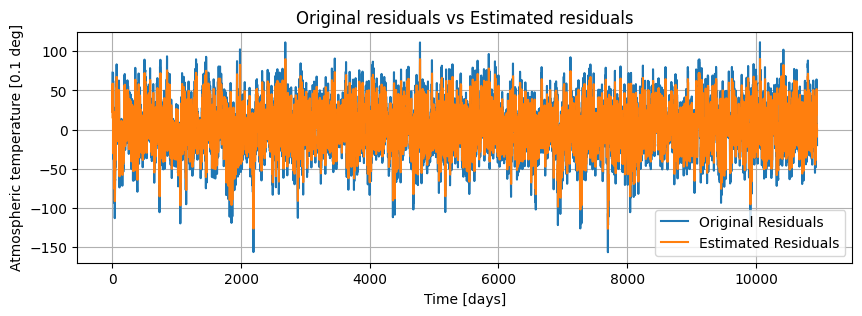

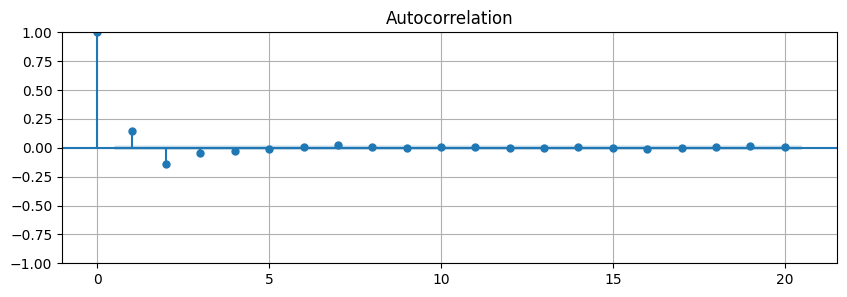

In [11]:
_, e_hat2, phi_1 = AR1(e_hat, time)

# Lets looks at the ACF plot of the residuals AFTER fitting the AR(1)-model
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat2, ax=ax, lags=20);
ax.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Task 3.5:</b>   
<p>

- Include the ACF plot of the residuals after fitting the AR(1) model in your report.
  
- What can you conclude from this ACF?
  
- Is the AR(1) model a good fit to the residuals?
  
- What would you do if the AR(1) model is not a good fit to the residuals?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Solution:</b>   
<p>
We see hardly any autocorrelation in the residuals of the AR(1) model; apart from the lag 0 entry, which is 1 by definition, the other values are approximately zero (hence, with a little bit of approximation we can say that the remaining residuals seem to result from a white noise process), so the AR(1) model is (quite) a good fit to the residuals of Part 2. If the AR(1) model is not a good fit to the residuals we could try a higher order AR model (which is beyond the scope of the MUDE).

The estimated AR(1) coefficient $\hat{\phi}_1$ is 0.81 (for De Bilt), which can also be observed from the ACF-plot with Task 3.1 (for lag = 1).
</p>
</div>

## Part 4: Forecasting

We have formed both the functional and stochastic model for the atmospheric temperature time series. The functional model consists of a linear trend (intercept and slope), and one periodic pattern ('frequency'), representing an annual cycle. The stochastic model is formed by an AR(1) noise process and we determined/estimated the $\phi_1$ parameter.

Now all is in place for forecasting, see Section 4.8 ['Time Series forecasting'](https://mude.citg.tudelft.nl/book/2025/time_series/forecasting.html) in the textbook, and soon you can start your own Weer-plaza, Buienradar or Weer-online ...

The best prediction results from using both the functional and stochastic model. The functional model is used to predict the trend ahead in time (i.e. the signal of interest), and the stochastic model accounts for the 'memory' in the remaining residuals (those of Part 2), and predicts the noise.



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">  

<b>Task 4.1:</b>   
<p>
Steps 1 and 2 of the procedure outlined in Section 4.8 'Time Series forecasting' have been completed already above. We now proceed to execute steps 3 - 5. Based on our 30 years of temperature time series, with 31-DEC-2020 being the last day in the data, we are curious to know the daily mean temperature on 01-JAN-2021 and on 05-JAN-2021, hence we predict <b>one day</b> ahead and <b>five days</b> ahead. Include the numerical predicted temperature values in your report.
</p>
</div>

Predicted daily mean temperatures
y_P1=24.387 [0.1 deg]
y_P5=32.123 [0.1 deg]
signal-part=40.401; noise-part=-16.014
signal-part=38.954; noise part=-6.830


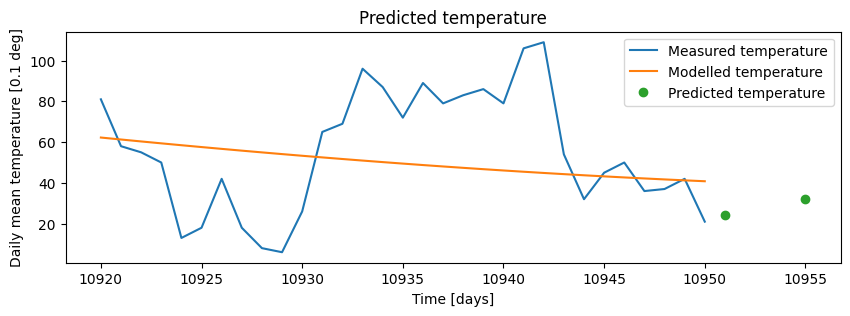

In [12]:
# set times of interest for prediction
timeP1 = len(data)+1   # one day ahead
timeP5 = len(data)+5   # five days ahead

# use estimate x_hat and (structure of) matrix A from Task 2.1 to predict signal of interest
A_P1 = np.array([1, timeP1, np.cos(2*np.pi*dom_f*timeP1), np.sin(2*np.pi*dom_f*timeP1)])
A_P5 = np.array([1, timeP5, np.cos(2*np.pi*dom_f*timeP5), np.sin(2*np.pi*dom_f*timeP5)])

# and use estimated phi-parameter of AR(1) noise model from Task 3.4, together with the last noise entry (i.e. e_hat from Task 2.1 for day 31-DEC-2020)
# NOTE: one could use the formal expression (step 4, Section 4.8) for epsilon_p-hat with the Sigma-matrices,
#       but it is much simpler to directly use the recursive expression for the AR-process, 
#       in this case for AR(1): S_{t} = phi_1 * S_{t-1} + epsilon_{t},
#       realizing that best prediction of white noise residual epsilon_t ahead in time equals zero (what else should you take?)

# putting things together -> final predictions
y_P1 = A_P1 @ x_hat + phi_1 * e_hat[len(data)-1]
y_P5 = A_P5 @ x_hat + phi_1**5 * e_hat[len(data)-1]

print(f'Predicted daily mean temperatures')
print(f'y_P1={y_P1:.3f} [0.1 deg]')
print(f'y_P5={y_P5:.3f} [0.1 deg]')

print(f'signal-part={A_P1@x_hat:.3f}; noise-part={phi_1*e_hat[len(data)-1]:.3f}' )
print(f'signal-part={A_P5@x_hat:.3f}; noise part={phi_1**5*e_hat[len(data)-1]:.3f}')

# figure showing last 31 days of measured temperature and predicted temperatures
plt.figure(figsize=(10,3))
plt.plot(time[len(data)-31:],data[len(data)-31:],label='Measured temperature')
plt.plot(time[len(data)-31:],y_hat[len(data)-31:],label='Modelled temperature')
plt.plot([timeP1, timeP5],[y_P1, y_P5],'o',label='Predicted temperature')
plt.xlabel('Time [days]')
plt.ylabel('Daily mean temperature [0.1 deg]')
plt.title('Predicted temperature')
plt.legend()

## Part 5: Analysis by KNMI

The KNMI (Royal Netherlands Meteorological Institute) has performed a similar analysis on these temperature time series, arriving at similar conclusions, though with using a slightly different functional model. In Task 1 and 2 we used a linear trend, plus an annual cycle, the latter being modelled by a (pure) cosine, i.e. the frequency was set to once per year, and the amplitude and phase were estimated using the data. Together with the linear trend we used four (or five, if you count the frequency in as well) unknown parameters in the model. That might pose actually quite a rigid model.

 ### Model by KNMI

KNMI used a less rigid model, with in principle 365 unknown parameters. For the functional model they assume that the temperature on a certain day is unknown, and that the temperature for the next day is another unknown (and not being related at all to the temperature on the previous day). The only strong modelling assumption is that the temperature behaviour is **identical** every year, so the temperature, according to their functional model, on 05-DEC-1995 is the same as the temperature on 05-DEC-1998. The yearly pattern (whatever that may be, a nice, clean cosine or some 'weird' behaviour) repeats every year.

In terms of a model of observation equations, there is one unknown temperature for each day of the year, and the measurements in one year are one-to-one related to these 365 unknown parameters, $x_{d1}$ through $x_{d365}$, and this repeats year after year. This reads (shown here for just the first two years of data, year 'y1' and 'y2'):
$$ E \left( \begin{array}{c} Y_{y1,d1} \\ Y_{y1,d2} \\ \vdots \\ Y_{y1,d365} \\ Y_{y2,d1} \\ Y_{y2,d2} \\ \vdots \\ Y_{y2,d365}  \end{array} \right) = \left( \begin{array}{cccc} 1 & 0 & \cdots & 0  \\ 0 & 1 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & 1 \\ 1 & 0 & \cdots & 0 \\ 0 & 1 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & 1 \end{array} \right) \left( \begin{array}{c} x_{d1} \\ x_{d2} \\ \vdots \\ x_{d365} \end{array} \right) $$
and the (unweighted) least-squares estimates for the 365 unknown $x$ parameters can be computed. Though, with this simple structure this can be done much easier! The estimate $\hat{X}_{d1}$ is simply the average or mean of all 'day 1' measurements (over 30 years), and the estimate $\hat{X}_{d2}$ the mean of all 'day 2' measurements, and so on, until $\hat{X}_{d365}$.

The analysis by the KNMI is presented in this news-item (https://www.knmi.nl/over-het-knmi/nieuws/temperature-memory-temperatuur-geheugen-nederland).



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Task 5.1:</b>   
<p>
Compute and make a plot of the daily temperature averaged over the 30 years time frame from 1991 to 2020. Include the resulting plot in your report.

Hint: this is most efficiently done using <code>np.reshape</code> on the data, and then taking the mean over <code>axis=0</code>.
</p>
</div>

Text(0.5, 1.0, 'Daily mean temperature - averaged over 30 years (1991-2020)')

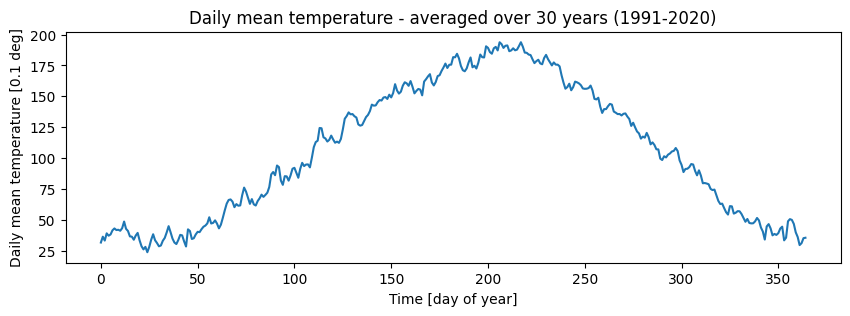

In [13]:
data_table=np.reshape(data,(30,365)) # data organized as matrix with 30 rows (one per year) and 365 columns (days)
mean_30years=data_table.mean(axis=0) # mean per column (hence, for each day, over 30 years)

plt.figure(figsize=(10,3))
plt.plot(mean_30years)
plt.xlabel('Time [day of year]')
plt.ylabel('Daily mean temperature [0.1 deg]')
plt.title('Daily mean temperature - averaged over 30 years (1991-2020)')



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> 

<b>Task 5.2:</b>   
<p>
Compute the residuals of the daily mean temperature time series (the input with Part 0) with respect to the 'daily temperature averaged over the 30 years time frame from 1991 to 2020' just computed in Task 5.1.

Finally compute and plot the normalized autocovariance function (ACF) of these residuals (include the ACF plot of the residuals in your report), and comment on this plot, e.g. comparing it with the ACF from Task 3.1.
</p>
</div>

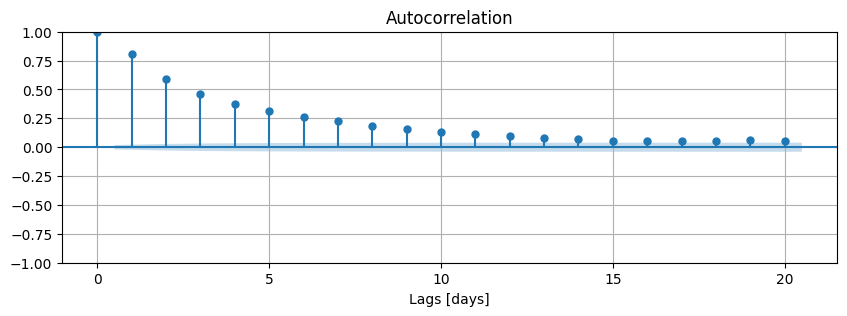

In [14]:
data_table_residuals=data_table-mean_30years # subtract mean-row from each row
KNMI_residuals=np.reshape(data_table_residuals,(len(data),1)) # turn table back into a single time series (vector)
fig, ax = plt.subplots(1,1, figsize=(10,3))
plot_acf(KNMI_residuals,ax=ax, lags=20)
ax.set_xlabel('Lags [days]')
ax.grid()

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Solution:</b>   
<p>
The autocorrelation of the residuals using the 'KNMI-functional-model' (30 years average) is very similar to what we obtained with our functional model (linear trend plus cosine) in Task 3.1.
</p>
</div>

### Final note

The graph (in the news-item on the KNMI-website) of the 'Temperatuur in De Bilt in 2005', where the solid curve shows the mean over the 30 years time frame 1991-2020, suggests, as this curve is rather smooth, that in addition KNMI applied some Moving Average operation (see the Appendix in the textbook). Your graph with Task 5.1 likely showed a larger degree of variability than the one by KNMI in the news-item.

> By Christiaan Tiberius and Serge Kaplev, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).